# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#looking at the table sizes
print('portfolio shape: ',portfolio.shape)
print('profile shape: ',profile.shape)
print('transcript shape: ',transcript.shape)

portfolio shape:  (10, 6)
profile shape:  (17000, 5)
transcript shape:  (306534, 4)


### Looking at the data

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [3]:
event_counts = transcript.event.value_counts()
event_counts

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Transforming portfolio data to be suitable for machine learning
This is more efficient than merging it onto larger datasets and transforming later on more records

In [4]:
portfolio_transformed = portfolio.copy()
#getting unique channels used
channels = set()
for row in portfolio['channels']:
    channels.update(set(row))

#Creating dummy variables for channels
for channel in channels:
    portfolio_transformed[channel] = 0
    
row_index = 0
for row in portfolio_transformed['channels']:
    col_index = 6
    for channel in channels:
        if channel in set(row):
            portfolio_transformed.iloc[row_index,col_index] = 1
        col_index += 1
    row_index += 1
#Creating dummy variables for offer_type
offer_dummies = pd.get_dummies(portfolio_transformed['offer_type'])
portfolio_transformed = pd.concat([portfolio_transformed, offer_dummies], axis=1)
#dropping columns that are no longer needed
#Also dropping informational to reduce multicollinearity
portfolio_transformed.drop(['channels','offer_type','informational'],axis=1,inplace=True)
portfolio_transformed

,difficulty,duration,id,reward,social,email,web,mobile,bogo,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0,1,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,1,0,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,0,1,1,1,0,1


### Looking at the profile data

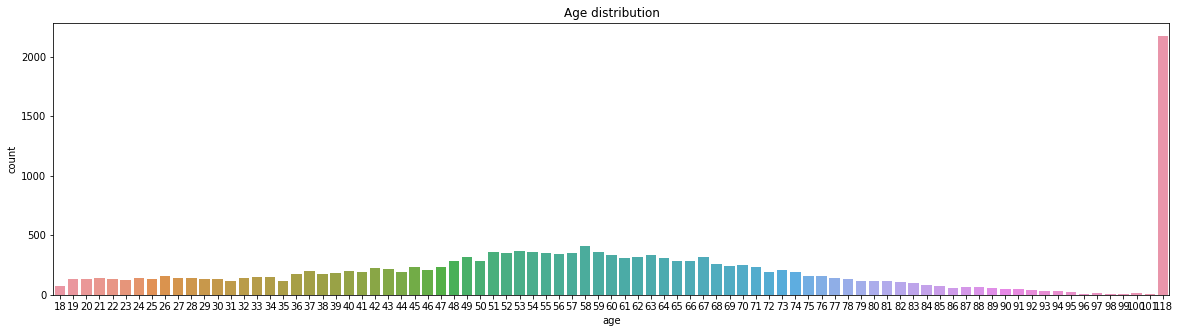

In [5]:
#Looking at the age variable
plt.figure(figsize=(20,5))
ax = sns.countplot(x='age', data=profile).set_title('Age distribution')

In [6]:
#The age 118 seems to being used as a dummy value
#Setting this to null
profile['age'] = profile.age.apply(lambda x: np.nan if x == 118 else x)
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


##### Looking at the null values

In [7]:
#Proportion of null values
print('percentage of nulls')
profile.isnull().sum(axis=0)/profile.count(axis=0)

percentage of nulls


age                 0.146712
became_member_on    0.000000
gender              0.146712
id                  0.000000
income              0.146712
dtype: float64

The above shows that around 15% of the values are missing for all fields

In [8]:
#Converting the became a member integer to the days since the first member so that it can be scaled properly
first_date, last_date = pd.to_datetime(profile['became_member_on'].agg(['min','max']), format='%Y%m%d')
print('first date', first_date)
print('last date', last_date)
profile['days_from_first_member'] = (pd.to_datetime(profile['became_member_on'], format='%Y%m%d') - first_date).dt.days
profile.drop('became_member_on',axis=1,inplace=True)
profile.head()

first date 2013-07-29 00:00:00
last date 2018-07-26 00:00:00


,age,gender,id,income,days_from_first_member
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1294
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1447
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1809
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1380
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,1467


##### checking to see if the null values are restricted to just a few days

In [9]:
#checking to see if the null values come from particular membership days
print("For nulls\n", profile[profile['age'].isnull()]['days_from_first_member'].agg(['min','max','mean','std']))
print("\nFor populated\n", profile[~profile['age'].isnull()]['days_from_first_member'].agg(['min','max','mean','std']))

For nulls
 min        4.000000
max     1823.000000
mean    1339.828966
std      350.201317
Name: days_from_first_member, dtype: float64

For populated
 min        0.000000
max     1823.000000
mean    1300.521012
std      419.205158
Name: days_from_first_member, dtype: float64


There doesn't seem to be any pattern for the nulls and the days the members were on-boarded.
Will wait till later for imputation to see if there are other differences when merged to other data

#### Looking at Gender

In [10]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Since the other gender pot is relatively small, we will change this to a boolean field of Male or not.
This will have the effect of putting null values and females in the same bucket, but these can be further split out later with a seperate field to say if the values weren't captured.

In [11]:
profile['male'] = (profile['gender'] == 'M')
profile.drop('gender',axis=1,inplace=True)
profile.head(10)

,age,id,income,days_from_first_member,male
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1294,False
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1447,False
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1809,False
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1380,False
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1467,False
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,1732,True
6,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,1519,False
7,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,1526,False
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,1656,True
9,NaN,8974fc5686fe429db53ddde067b88302,NaN,1212,False


### Transforming the transcript data

In [12]:
#splitting out the value field
value_splits = json_normalize(transcript['value'])
all_events_df = pd.concat([transcript, value_splits], axis=1)
all_events_df.head()

,event,person,time,value,amount,offer id,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


Checking what values are recorded for what events

In [13]:
cols_to_check = ['amount','offer id','offer_id','reward']

nulls = all_events_df[cols_to_check].isnull()
nulls_by_event = pd.concat([all_events_df['event'], nulls], axis=1)
nulls_by_event = nulls_by_event.groupby('event').sum()
nulls_by_event = pd.concat([nulls_by_event, event_counts], axis=1, sort=True)

for col in cols_to_check:
    nulls_by_event[col] = nulls_by_event[col]/nulls_by_event['event']

nulls_by_event

,amount,offer id,offer_id,reward,event
offer completed,1.0,1.0,0.0,0.0,33579
offer received,1.0,0.0,1.0,1.0,76277
offer viewed,1.0,0.0,1.0,1.0,57725
transaction,0.0,1.0,1.0,1.0,138953


The above tables shows:
- Transactions only have amount values
- Offers viewed only have 'offer id' values
- Offers recevied only have 'offer id' values
- Offers completed have both 'offer_id' and 'reward'
- There are no missing values for the fields connected to each event

### Splitting out the events into 4 distinct tables

In [14]:
#Transaction table
transaction_df = all_events_df[all_events_df['event'] == 'transaction'].copy()
transaction_df = transaction_df[['person','time','amount']].reset_index(drop=True)
#Creating unique key for each transaction
transaction_df['tran_id'] = (transaction_df['person'] 
                             + "_" + transaction_df['time'].map(str) 
                             + "_" + transaction_df['amount'].round(2).map(str)
                            )
transaction_df = transaction_df[['tran_id','person','time','amount']]
print('Transaction Table')
transaction_df.head()

Transaction Table


,tran_id,person,time,amount
0,02c083884c7d45b39cc68e1314fec56c_0_0.83,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f_0_34.56,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717_0_13.23,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2_0_19.51,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52_0_18.97,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [15]:
#received table
received_df = all_events_df[all_events_df['event'] == 'offer received'].copy()
received_df = received_df[['person','time','offer id']].rename(columns={"offer id": "offer_id"}).reset_index(drop=True)
#merging on duration to received table
received_df = received_df.merge(portfolio[['id','duration']],how='left', left_on='offer_id', right_on='id')
received_df.drop('id',axis=1,inplace=True)
#Creating a unique key to track the event of each promotional mateirial being sent
received_df['marketing_id'] = (received_df['person'] 
                             + "_" + received_df['time'].map(str)
                             + "_" + received_df['offer_id']
                            )
received_df = received_df[['marketing_id','person','time','duration','offer_id']]
print('Received Table: {0} records'.format(received_df.shape[0]))
received_df.head()

Received Table: 76277 records


,marketing_id,person,time,duration,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0


In [16]:
#viewed table
viewed_df = all_events_df[all_events_df['event'] == 'offer viewed'].copy()
viewed_df = viewed_df[['person','time','offer id']].rename(columns={"offer id": "offer_id"}).reset_index(drop=True)
print('Views Table: {0} records'.format(viewed_df.shape[0]))
viewed_df.head()

Views Table: 57725 records


,person,time,offer_id
0,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [17]:
#completed table
completed_df = all_events_df[all_events_df['event'] == 'offer completed'].copy()
completed_df = completed_df[['person','time','offer_id','reward']].reset_index(drop=True)
print('Completion Table: {0} records'.format(completed_df.shape[0]))
completed_df.head()

Completion Table: 33579 records


,person,time,offer_id,reward
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2.0
1,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2.0
2,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
3,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10.0
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


### Appending information to the received table
This will allow us to measure the effectiveness of each material sent to each individual

In [18]:
#creating dataframe of merged received and viewed tables
received_viewed_df = pd.merge(received_df[['marketing_id','person','time','duration','offer_id']]
                            ,viewed_df
                           ,on=['person','offer_id']
                           ,how='inner')
#adding flag to say if it was viewed while the promotion was active
received_viewed_df['In Scope'] = ((received_viewed_df['time_y'] >= received_viewed_df['time_x']) #saying it must be viewed after it was received
                                     & (received_viewed_df['time_y'] <= (received_viewed_df['time_x'] 
                                                                              + (received_viewed_df['duration']*24)
                                                                             )#saying it should be viewed within the duration the material is active for
                                       )
                                  )
#Adding field to origional received df to say if it was viewed in time
viewed_in_time = received_viewed_df[received_viewed_df['In Scope']]['marketing_id'].unique()
received_df['viewed_in_time'] = received_df['marketing_id'].isin(viewed_in_time)
received_df.head()

,marketing_id,person,time,duration,offer_id,viewed_in_time
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,True
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,True
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5,True
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4,True
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,True


In [19]:
#creating dataframe of merged received and completed tables
received_completed_df = pd.merge(received_df[['marketing_id','person','time','duration','offer_id']]
                            ,completed_df
                           ,on=['person','offer_id']
                           ,how='inner')
#adding flag to say if it was viewed while the promotion was completed
received_completed_df['In Scope'] = ((received_completed_df['time_y'] >= received_completed_df['time_x'])
                                     & (received_completed_df['time_y'] <= (received_completed_df['time_x'] 
                                                                              + (received_completed_df['duration']*24)
                                                                             )
                                       )
                                  )
#Adding field to origional received df to say if it was viewed in time
completed_in_time = received_completed_df[received_completed_df['In Scope']]['marketing_id'].unique()
received_df['completed_in_time'] = received_df['marketing_id'].isin(completed_in_time)
received_df.head()

,marketing_id,person,time,duration,offer_id,viewed_in_time,completed_in_time
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5,True,False
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4,True,False
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,True,False


In [20]:
#Adding a final tag for where the promotion was both viewed and completed
received_df['final_completed'] = received_df['completed_in_time'] & received_df['viewed_in_time']
received_df.head()

,marketing_id,person,time,duration,offer_id,viewed_in_time,completed_in_time,final_completed
0,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,78afa995795e4d85b5d9ceeca43f5fef,0,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True
1,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,a03223e636434f42ac4c3df47e8bac43,0,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,False
2,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,e2127556f4f64592b11af22de27a7932,0,7,2906b810c7d4411798c6938adc9daaa5,True,False,False
3,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,8ec6ce2a7e7949b1bf142def7d0e0586,0,10,fafdcd668e3743c1bb461111dcafc2a4,True,False,False
4,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,68617ca6246f4fbc85e91a2a49552598,0,5,4d5c57ea9a6940dd891ad53e9dbe8da0,True,False,False


In [21]:
#Looking at the proportion of each event that happens after the promotional material is sent
received_df[['viewed_in_time','completed_in_time','final_completed']].sum()/received_df.shape[0]

viewed_in_time       0.745900
completed_in_time    0.440906
final_completed      0.365733
dtype: float64

### Merging on personal and offer features

In [22]:
offers_cleaned = received_df.merge(portfolio_transformed[['id','difficulty','reward','social'
                                                       ,'mobile','web','email','bogo','discount']]
                                ,how='left'
                                , left_on='offer_id'
                                , right_on='id')
offers_cleaned.drop('id',axis=1,inplace=True)
offers_cleaned = offers_cleaned.merge(profile[['id','age','days_from_first_member','male','income']]
                                ,how='left'
                                , left_on='person'
                                , right_on='id')

offers_cleaned = offers_cleaned[['final_completed','duration','difficulty','reward','social'
                                 ,'mobile','web','email','bogo','discount','age','days_from_first_member'
                                 ,'male','income']]
offers_cleaned['profile_null'] = offers_cleaned.age.isnull()
offers_cleaned.head()

,final_completed,duration,difficulty,reward,social,mobile,web,email,bogo,discount,age,days_from_first_member,male,income,profile_null
0,True,7,5,5,0,1,1,1,1,0,75.0,1380,False,100000.0,False
1,False,10,20,5,0,0,1,1,0,1,NaN,1467,False,NaN,True
2,False,7,10,2,0,1,1,1,0,1,68.0,1732,True,70000.0,False
3,False,10,10,2,1,1,1,1,0,1,NaN,1519,False,NaN,True
4,False,5,10,10,1,1,1,1,1,0,NaN,1526,False,NaN,True


In [23]:
#Scale features
def apply_min_max(df,fields_list):
    """
    Input: df - the dataframe containing the columns you want to apply min max scaling
                this dataset will be updated inplace, with no outputs
           field_list - the list of column names that the transformation should be applied to
    
    """
    for col in fields_list:
        min_val = df[col].min()
        max_val = df[col].max()
        range_val = max_val - min_val
        df[col] = (df[col] - min_val)/range_val
        
apply_min_max(offers_cleaned,['duration','difficulty','reward','age','days_from_first_member','income'])
offers_cleaned.head()

,final_completed,duration,difficulty,reward,social,mobile,web,email,bogo,discount,age,days_from_first_member,male,income,profile_null
0,True,0.571429,0.25,0.5,0,1,1,1,1,0,0.686747,0.756994,False,0.777778,False
1,False,1.000000,1.00,0.5,0,0,1,1,0,1,NaN,0.804717,False,NaN,True
2,False,0.571429,0.50,0.2,0,1,1,1,0,1,0.602410,0.950082,True,0.444444,False
3,False,1.000000,0.50,0.2,1,1,1,1,0,1,NaN,0.833242,False,NaN,True
4,False,0.285714,0.50,1.0,1,1,1,1,1,0,NaN,0.837082,False,NaN,True


In [24]:
#Imputing the null values in age and income
offers_cleaned['age'].fillna(value=offers_cleaned.age.median(), inplace=True)
offers_cleaned['income'].fillna(value=offers_cleaned.age.median(), inplace=True)
offers_cleaned.head()

,final_completed,duration,difficulty,reward,social,mobile,web,email,bogo,discount,age,days_from_first_member,male,income,profile_null
0,True,0.571429,0.25,0.5,0,1,1,1,1,0,0.686747,0.756994,False,0.777778,False
1,False,1.000000,1.00,0.5,0,0,1,1,0,1,0.445783,0.804717,False,0.445783,True
2,False,0.571429,0.50,0.2,0,1,1,1,0,1,0.602410,0.950082,True,0.444444,False
3,False,1.000000,0.50,0.2,1,1,1,1,0,1,0.445783,0.833242,False,0.445783,True
4,False,0.285714,0.50,1.0,1,1,1,1,1,0,0.445783,0.837082,False,0.445783,True


In [25]:
#checking the correlation matrix
offers_cleaned.corr()

,final_completed,duration,difficulty,reward,social,mobile,web,email,bogo,discount,age,days_from_first_member,male,income,profile_null
final_completed,1.000000,0.241956,0.150864,0.168026,0.229660,0.106855,0.158744,NaN,0.123219,0.186348,0.060376,-0.140915,-0.008440,0.117922,-0.207111
duration,0.241956,1.000000,0.808819,0.161343,-0.186342,-0.530926,0.340611,NaN,-0.184673,0.740795,-0.003004,-0.000700,0.005327,-0.002602,-0.004582
difficulty,0.150864,0.808819,1.000000,0.465266,-0.155788,-0.742022,0.243484,NaN,-0.030579,0.597890,-0.003863,-0.001505,0.002543,-0.001038,-0.003036
reward,0.168026,0.161343,0.465266,1.000000,0.287685,-0.078530,-0.119477,NaN,0.792164,-0.288069,-0.004004,-0.002179,-0.000093,0.002002,0.002136
social,0.229660,-0.186342,-0.155788,0.287685,1.000000,0.408517,-0.409522,NaN,0.248770,-0.166475,-0.000227,0.003706,0.001241,0.004605,0.002086
mobile,0.106855,-0.530926,-0.742022,-0.078530,0.408517,1.000000,-0.167296,NaN,0.272876,-0.409086,-0.000155,0.001795,0.000614,0.003197,0.005317
web,0.158744,0.340611,0.243484,-0.119477,-0.409522,-0.167296,1.000000,NaN,-0.103650,0.408952,-0.000239,0.002186,0.002693,-0.004105,0.000768
email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bogo,0.123219,-0.184673,-0.030579,0.792164,0.248770,0.272876,-0.103650,NaN,1.000000,-0.667038,-0.001550,-0.001954,-0.002018,0.002190,0.004252
discount,0.186348,0.740795,0.597890,-0.288069,-0.166475,-0.409086,0.408952,NaN,-0.667038,1.000000,-0.002608,0.003780,0.004618,-0.002082,-0.002844


The chance of someone using an offer looks to be impacted the most by the duration of the promotion.
Email is showing as NaN because all promotions included email, so we can drop this.

In [26]:
offers_cleaned.drop('email',axis=1,inplace=True)

In [52]:
offers_cleaned.to_pickle('cleaned_df.pkl')

##### Comparing some of the fields where there is no data for the individuals

In [44]:
#Looking at where the income, gender and age are missing
null_pop = offers_cleaned[offers_cleaned.profile_null]
#Looking at where the income, gender and age are not missing
not_null_pop = offers_cleaned[~offers_cleaned.profile_null]
#putting the two populations into a list
compare_pops = [null_pop,not_null_pop]

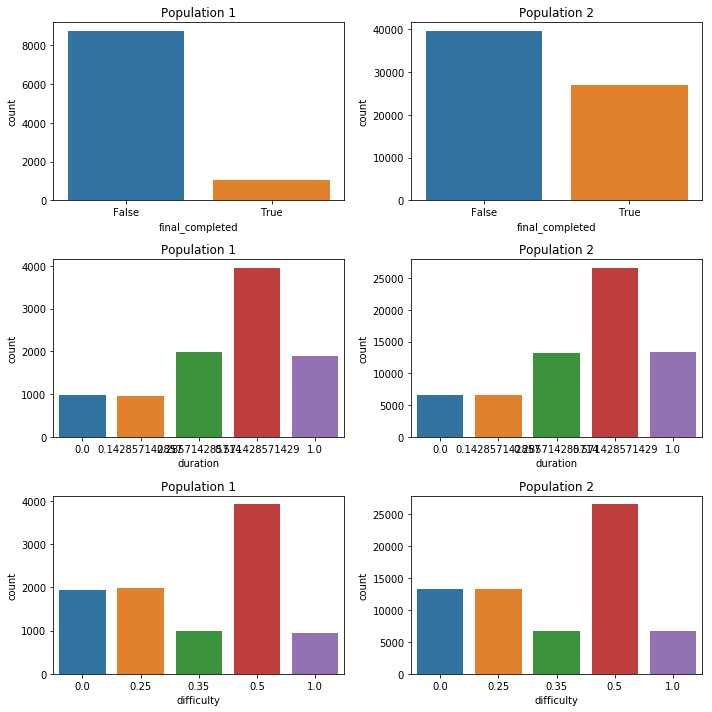

In [39]:
def compare_populations(population_list,cols_to_check):
    """
    Input:population_list - A list of dataframes containing different populations that you want to compare.
                          - Graphs will be output for each population
          cols_to_check   - The fields that you want to use countplot on to graph for each population
    """
    plt.figure(figsize=(10,10))
    graph_rows = len(cols_to_check)
    graph_cols = len(population_list)
    for row_index, col in enumerate(cols_to_check):
        for col_index, population in enumerate(population_list):
            index = (row_index*graph_cols + col_index) + 1
            plt.subplot(graph_rows,graph_cols,index)
            ax = sns.countplot(x=col, data=population).set_title('Population ' + str(col_index + 1))
    plt.tight_layout()
    plt.show()
compare_populations(compare_pops,['final_completed','duration','difficulty'])

In [43]:
print("Proportion completed in null population",null_pop['final_completed'].sum()/null_pop.shape[0])
print("Proportion completed with no nulls",not_null_pop['final_completed'].sum()/not_null_pop.shape[0])

Proportion completed in null population 0.105564648118
Proportion completed with no nulls 0.403978887536


The above graphs show that there was no bias in how the offers were sent to the populations without personal details.
However the populations are qualitatively different as only 11% of the individuals without details completed their offer, compared with 40% with details. 

### Modelling to see how much variation in using the offers we can explain from the fields we have

The datasets are already sorted. We will therefore take the first 80% of the records for our training population, and the last 20% as our test population. This ensures that our testing population will be closer to the outcomes in any live environment, as the customers will be a bit aged from the training data.

In [51]:
def split_test_train(df,train_size):
    cut_off = round(df.shape[0]*(1-train_size))
    train_pop = df.iloc[0:cut_off,:]
    test_pop = df.iloc[cut_off:,:]
    print(df.shape,train_pop.shape,test_pop.shape)
split_test_train(not_null_pop,0.2)

(66501, 14) (53201, 14) (13300, 14)


In [48]:
df_length = not_null_pop.shape[0]
print('Size of population without missing details',df_length)
cut_off = round(df_length*(1-0.2))

Size of population without missing details 66501


13300

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state=42) 

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

In [11]:
#appending marker to transaction table to say if it was part in scope for a promotion
transaction_received_df = pd.merge(transaction_df[['tran_id','person','time']]
                            ,received_df
                           ,on='person'
                           ,how='inner')
transaction_received_df['In Scope'] = ((transaction_received_df['time_y'] >= transaction_received_df['time_x'])
                                     & (transaction_received_df['time_y'] <= (transaction_received_df['time_x'] 
                                                                              + transaction_received_df['duration']
                                                                             )
                                       )
                                      )
transaction_received_df.head()
#validate='m:1'

,tran_id,person,time_x,time_y,offer_id,duration,marketing_id,In Scope
0,02c083884c7d45b39cc68e1314fec56c_0_0.83,02c083884c7d45b39cc68e1314fec56c,0,0,ae264e3637204a6fb9bb56bc8210ddfd,7,02c083884c7d45b39cc68e1314fec56c_0_ae264e36372...,True
1,02c083884c7d45b39cc68e1314fec56c_0_0.83,02c083884c7d45b39cc68e1314fec56c,0,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,02c083884c7d45b39cc68e1314fec56c_408_0b1e1539f...,False
2,02c083884c7d45b39cc68e1314fec56c_6_1.44,02c083884c7d45b39cc68e1314fec56c,6,0,ae264e3637204a6fb9bb56bc8210ddfd,7,02c083884c7d45b39cc68e1314fec56c_0_ae264e36372...,False
3,02c083884c7d45b39cc68e1314fec56c_6_1.44,02c083884c7d45b39cc68e1314fec56c,6,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,02c083884c7d45b39cc68e1314fec56c_408_0b1e1539f...,False
4,02c083884c7d45b39cc68e1314fec56c_12_4.56,02c083884c7d45b39cc68e1314fec56c,12,0,ae264e3637204a6fb9bb56bc8210ddfd,7,02c083884c7d45b39cc68e1314fec56c_0_ae264e36372...,False


In [12]:
#appending whether transaction was eligbale to be part of a promotion to transaction table
eligable_trans = transaction_received_df[transaction_received_df['In Scope']]['tran_id'].unique()
transaction_df['eligable_promotion'] = transaction_df['tran_id'].isin(eligable_trans)
transaction_df.head()

,tran_id,person,time,amount,eligable_promotion
0,02c083884c7d45b39cc68e1314fec56c_0_0.83,02c083884c7d45b39cc68e1314fec56c,0,0.83,True
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f_0_34.56,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,True
2,54890f68699049c2a04d415abc25e717_0_13.23,54890f68699049c2a04d415abc25e717,0,13.23,False
3,b2f1cd155b864803ad8334cdf13c4bd2_0_19.51,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,True
4,fe97aa22dd3e48c8b143116a8403dd52_0_18.97,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,True


,person,time,offer_id,duration,marketing_id,viewed_in_time,completed_in_time,final_completed,difficulty,channels,offer_type,reward,age,became_member_on,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,78afa995795e4d85b5d9ceeca43f5fef_0_9b98b8c7a33...,True,False,False,5,"[web, email, mobile]",bogo,5,75,20170509,F,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,a03223e636434f42ac4c3df47e8bac43_0_0b1e1539f2c...,True,False,False,20,"[web, email]",discount,5,118,20170804,None,NaN
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,7,e2127556f4f64592b11af22de27a7932_0_2906b810c7d...,False,False,False,10,"[web, email, mobile]",discount,2,68,20180426,M,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,10,8ec6ce2a7e7949b1bf142def7d0e0586_0_fafdcd668e3...,False,False,False,10,"[web, email, mobile, social]",discount,2,118,20170925,None,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,5,68617ca6246f4fbc85e91a2a49552598_0_4d5c57ea9a6...,False,False,False,10,"[web, email, mobile, social]",bogo,10,118,20171002,None,NaN


In [49]:
received_df.to_pickle('received_df.pickle')

In [ ]:
received_df = pd.read_pickle('received_df.pickle')

### Getting data ready for machine learning model

In [63]:
received_df['channels'].head()

0            [web, email, mobile]
1                    [web, email]
2            [web, email, mobile]
3    [web, email, mobile, social]
4    [web, email, mobile, social]
Name: channels, dtype: object

In [62]:
received_df['channels'].head().str.split(',')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: channels, dtype: float64

In [79]:
transcript[transcript['event'] == 'offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [15]:
transaction_df = transcript[transcript['event'] == 'transaction'].copy()
transaction_df.reset_index(inplace=True)
transaction_split = json_normalize(transaction_df['value'])
transaction_split.head()

,amount
0,0.83
1,34.56
2,13.23
3,19.51
4,18.97


In [19]:
transaction_df['amount'] = transaction_split['amount']
transaction_df.drop(['index','event','value'],axis=1,inplace=True)
transaction_df.head()

,person,time,amount
0,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,54890f68699049c2a04d415abc25e717,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [21]:
offer_received_df = transcript[transcript['event'] == 'offer received'].copy()
offer_received_df.reset_index(inplace=True)
received_split = json_normalize(offer_received_df['value'])
received_split.head()

,offer id
0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2906b810c7d4411798c6938adc9daaa5
3,fafdcd668e3743c1bb461111dcafc2a4
4,4d5c57ea9a6940dd891ad53e9dbe8da0


In [25]:
offer_received_df['offer_id'] = received_split['offer id']
offer_received_df.drop(['index','event','value'],axis=1,inplace=True)
offer_received_df.head()

,person,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [27]:
offer_viewed_df = transcript[transcript['event'] == 'offer viewed'].copy()
offer_viewed_df.reset_index(inplace=True)
viewed_split = json_normalize(offer_viewed_df['value'])
viewed_split.head()

,offer id
0,f19421c1d4aa40978ebb69ca19b0e20d
1,5a8bc65990b245e5a138643cd4eb9837
2,4d5c57ea9a6940dd891ad53e9dbe8da0
3,ae264e3637204a6fb9bb56bc8210ddfd
4,5a8bc65990b245e5a138643cd4eb9837


In [28]:
offer_viewed_df['offer_id'] = viewed_split['offer id']
offer_viewed_df.drop(['index','event','value'],axis=1,inplace=True)
offer_viewed_df.head()

,person,time,offer_id
0,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
1,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
2,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
4,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [29]:
offer_completed_df = transcript[transcript['event'] == 'offer completed'].copy()
offer_completed_df.reset_index(inplace=True)
completed_split = json_normalize(offer_completed_df['value'])
completed_split.head()

,offer_id,reward
0,2906b810c7d4411798c6938adc9daaa5,2
1,fafdcd668e3743c1bb461111dcafc2a4,2
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
3,ae264e3637204a6fb9bb56bc8210ddfd,10
4,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [30]:
offer_completed_df['offer_id'] = completed_split['offer_id']
offer_completed_df['reward'] = completed_split['reward']
offer_completed_df.drop(['index','event','value'],axis=1,inplace=True)
offer_completed_df.head()

,person,time,offer_id,reward
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2
1,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2
2,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
3,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [29]:
#using json_normalize instead of a customer apply function for better performance
value_split = json_normalize(transcript['value'])
value_split.columns
#pd.concat([transcript, value_split], axis=1)

Index(['amount', 'offer id', 'offer_id', 'reward'], dtype='object')

In [44]:
#looking to see if multiple events are recorded in single values
value_split.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [49]:
nulls_per_row = value_split.isnull().sum(axis=1)

In [50]:
nulls_per_row.value_counts()

3    272955
2     33579
dtype: int64

In [72]:
#viewing some rows
test_twos = nulls_per_row[nulls_per_row == 2].head().index
value_split.loc[test_twos.tolist()]

,amount,offer id,offer_id,reward
12658,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


In [73]:
value_split[~value_split['amount'].isnull()].head()

,amount,offer id,offer_id,reward
12654,0.83,NaN,NaN,NaN
12657,34.56,NaN,NaN,NaN
12659,13.23,NaN,NaN,NaN
12670,19.51,NaN,NaN,NaN
12671,18.97,NaN,NaN,NaN


In [78]:
transcript.loc[[0,1,12651,12652,12653,12654,12657,12672,12679]]

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...


In [82]:
transcript[transcript['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']

,event,person,time,value
107,offer received,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
15578,offer viewed,fe97aa22dd3e48c8b143116a8403dd52,6,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
24238,transaction,fe97aa22dd3e48c8b143116a8403dd52,30,{'amount': 13.9}
38230,transaction,fe97aa22dd3e48c8b143116a8403dd52,84,{'amount': 16.99}
39554,transaction,fe97aa22dd3e48c8b143116a8403dd52,90,{'amount': 13.96}
53283,offer received,fe97aa22dd3e48c8b143116a8403dd52,168,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
79443,offer viewed,fe97aa22dd3e48c8b143116a8403dd52,198,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
79444,transaction,fe97aa22dd3e48c8b143116a8403dd52,198,{'amount': 28.71}
